In [122]:
# coding=utf-8
import requests
import pandas as pd
import numpy as np
import seaborn as sn
import geopandas, geoplot, random, re, scipy
from bs4 import BeautifulSoup as BS
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig

# Predefined variables

In [123]:
rankings = ['THE', 'QS', 'CWUR', 'ARWU']
countries = {
    'AG': 'Argentina', 'AU': 'Austria', 'AUS': 'Australia', 'BE': 'Belgium', 'BEL': 'Belarus', 'BZ': 'Brazil',
    'CA': 'Canada', 'CH': 'China', 'CHI': 'Chile', 'COL': 'Colombia', 'CZ': 'Czech', 'DN': 'Denmark',
    'EG': 'Egypt', 'ES': 'Estonia', 'FI': 'Finland', 'FR': 'France', 'GE': 'Germany', 'GR': 'Greece',
    'IN': 'India', 'ID': 'Indonesia', 'IR': 'Ireland', 'IRN': 'Iran', 'IT': 'Italy', 'IS': 'Izrael',
    'JP': 'Japan', 'KO': 'Korea', 'KZ': 'Kazakhstan', 'LE': 'Lebanon', 'MA': 'Malaysia', 'ME': 'Mexico',
    'NE': 'Netherlands', 'NO': 'Norway', 'NZ': 'New Zealand', 'PH': 'Philippines', 'PAK': 'Pakistan',
    'POL': 'Poland', 'POR': 'Portugal', 'RU': 'Russia', 'SA': 'South Africa', 'SAU': 'Saudi Arabia',
    'SG': 'Singapore', 'SP': 'Spain', 'SW': 'Sweden', 'TH': 'Thailand', 'UA': 'Ukraine',
    'UAE': 'United Arab Emirates', 'UK': 'United Kingdom', 'US': 'United States of America'
}

media_dir = 'Media/'
EDA_dir = 'Media/EDA/'
rankings_dir = 'Media/Rankings'

inputs = list(map(str, list(range(1, 57))))
inputs.remove('47')
outputs = ['E.1', 'E.2', 'E.3', 'E.4', 'E.5', 'E.6', 'E.8']

edu = list(map(str, list(range(1, 10))))
science = list(map(str, list(range(10, 21))))
staff = list(map(str, list(range(21, 30))))
inter = list(map(str, list(range(30, 39))))
infra = list(map(str, list(range(39, 47))))
fin = list(map(str, list(range(48, 57))))

# User defined functions

In [124]:
def set_rank(rank_range):
    """
    Set university rank if it is defined as range, but not a single value
    
    Parameters:
    rank_range (str): Consists university rank. Two formats: "a-b" or "c+", where a, b, c are integers and a < b
    
    Return
    int: University rank as an integer
    """
    
    range_min_max = re.search('(\d+)?-?(\d+)?\+?', rank_range)

    if range_min_max[2] is None:
        return range_min_max[1]
    else:
        rank = random.randint( int(range_min_max[1]), int(range_min_max[2]) )
        return rank

In [125]:
def kendall_w(data):
    """
    Calculate and return Kendall's coefficient of concordance
    
    Parameters
    data (Pandas dataframe): Dataframe of data
    
    Return
    int: W coefficient
    """
    
    m = 4
    n = len(data)

    Ri = data.sum(axis = 1)
#     Rm = np.sum(Ri) / n
    
    T = 0
    for ranking in data:
        vc = data[ranking].value_counts()
        d = vc[vc > 1]
        t = np.sum(list(map(lambda t: t ** 3 - t, d)))
        T = T + t
    
    W = (12 * np.sum(Ri) - 3 * m ** 2 * n * (n + 1) ** 2) / (m ** 2 * n * (n ** 2 - 1) - m * T)
#     S = np.sum( (Ri - Rm) ** 2 )
#     W = (12 * S) / ((m ** 2) * (n ** 3 - n) - 3 * (n + 1) / (n - 1))
    
    rS = (m * W - 1) / (m - 1)

    return (T, W, rS)

# Web scrapers

### Parse all Russian universities

In [12]:
url = 'http://indicators.miccedu.ru/monitoring/index.php?m=vpo'
r = requests.get(url)
r.encoding = r.apparent_encoding
page = BS(r.text, 'html.parser')

columns = []
uni_id_list = []
uni = []
data = pd.DataFrame(data = [[0, 1, 2, 3, 4]],
                    columns = ['uni_id', 'index', 'desc', 'dim', 'measure'])

for state in page.select('p.MsoListParagraph a[href]'): # through regions
    region_url = host + str(year) + '/' + state['href']
    r = requests.get(region_url)
    r.encoding = r.apparent_encoding
    state_page = BS(r.content)
    
    for uni in state_page.select('.blockcontent tr td.inst a[href]'): # through unis
        uni_id = int(uni['href'][12:])
        uni.append(uni.get_text())
        uni_id_list.append(uni_id)
        uni_url = host + '_vpo/' + uni['href']
        r = requests.get(uni_url)
        r.encoding = r.apparent_encoding
        uni_page = BS(r.content)
                    
        for indicator in uni_page.select('table#analis_dop tr'): # through the last table
            fields = []
            td_num = len(indicator.find_all('td'))
            
            if td_num == 4: # skip headings and not full rows
                for td in indicator.select('td'):
                    fields.append(td.get_text())
                row = pd.DataFrame(data = [[uni_id, fields[0], fields[1], fields[2], fields[3]]],
                                    columns = ['uni_id', 'index', 'desc', 'dim', 'measure'])
                data = data.append(row)

data = data.iloc[3:, :]
data.set_index('uni_id', inplace = True)
data.to_excel('russian_uni.xlsx', index = False)

### Parse Desired Russian Universities

In [126]:
url = 'http://indicators.miccedu.ru/monitoring/_vpo/inst.php?id='
unis = pd.read_excel('Data/Russian_Universities_Initial.xlsx')

for index, uni in unis.iterrows():
    r = requests.get(url + str(uni.Uni_Id))
    r.encoding = r.apparent_encoding
    page = BS(r.text, 'html.parser')
    
    
    for indicator in page.select('table#analis_dop tr'): # through the last table
        fields = []
        td_num = len(indicator.find_all('td'))
            
        if td_num == 4: # skip headings and not full rows
            not_valid = False
            for ix, td in enumerate(indicator.select('td')):
                if re.search('№', td.get_text()) or (ix == 2 and re.search('да', td.get_text())):
                    not_valid = True
                    break
                else:
                    fields.append(td.get_text())
            
            if not_valid == False:
                unis.loc[index, str(fields[0])] = float(fields[3].replace(' ', '').replace(',', '.'))

    for table in page.select('table.napde'):        
        row = []
        for ix, indicator in enumerate(table.select('td')): # through the last table
            if ix in [0, 1, 2, 3]:
                continue
            else:
                res = divmod(ix, 4)
                if res[1] in [0, 3]:
                    row.append(indicator.get_text())
                    
                if res[1] == 3:
                    unis.loc[index, str(row[0])] = float(row[1].replace(' ', '').replace(',', '.'))
                    row = []

    # working with outpus
    # there is an additional empty tbody before thead of the result table, so we cannot use BS
    # use regex instead
    Es = re.findall('(E\.\d)</td>', str(page))
    output_values = re.findall('right center no-repeat;\">(\d+(?:,\d+)?)<', str(page))
    income = re.findall('<span style=\"\">(\d+(?:,\d+)?)<', str(page))
    output_values.insert(4, income[0])
    
    for ix, val in enumerate(output_values):
        unis.loc[index, Es[ix]] = float(val.replace(',', '.'))

### Set university ranks

In [131]:
for index, university in unis.iterrows():
    for ranking in ['THE', 'QS', 'CWUR', 'ARWU']:
        value = unis.loc[unis.University == university[0], ranking]
        if not (isinstance(value[index], int) or value[index] is None or isinstance( value[index], float)):
            unis.loc[unis.University == university[0], ranking] = set_rank(value[index])
            
unis.to_excel('Data/Russian_Universities.xlsx', index = False)

### Set university ranks for rankings time series

In [140]:
data = pd.read_excel('Data/Russian_Universities_TS_Initial.xlsx')
data.loc[(data.Year == 2020) & (data.Ranking == 'THE'), 'Rank'] = unis.THE
data.loc[(data.Year == 2020) & (data.Ranking == 'QS'), 'Rank'] = unis.QS
data.loc[(data.Year == 2020) & (data.Ranking == 'ARWU'), 'Rank'] = unis.ARWU
data.loc[(data.Year == 2020) & (data.Ranking == 'CWUR'), 'Rank'] = unis.CWUR

for index, row in data.iterrows():
    value = data.loc[data.University == row[0], 'Rank']
    if not (isinstance(value[index], int) or value[index] is None or isinstance( value[index], float)):
        data.loc[data.University == row[0], 'Rank'] = set_rank(value[index])

data.to_excel('Data/Russian_Universities_TS.xlsx', index = False)

### Parse Shanghai Ranking

In [138]:
url = 'http://www.shanghairanking.com/ARWU2019.html'
r = requests.get(url)
page = BS(r.text, 'html.parser')

data = pd.DataFrame(data = [[0, 1, 2, 3, 4, 5, 6, 7]],
                    columns = ['Rank', 'Uni', 'Alumni', 'Award', 'HiCi', 'N&S', 'PUB', 'PCP'])

for i, uni in enumerate(page.select('table#UniversityRanking tr')):
    if i == 0:
        continue
    else:
        fields = []
        for j, indicator in enumerate(uni.select('td')):
            if j in [0, 1, 5, 6, 7, 8, 9, 10]:
                if j == 1:
                    ind = (indicator.select('a'))[0].text
                else:
                    ind = indicator.text
                fields.append(ind)
        row = pd.DataFrame(data = [[fields[0], fields[1], fields[2], fields[3], fields[4], fields[5], fields[6], fields[7]]],
                                    columns = ['Rank', 'Uni', 'Alumni', 'Award', 'HiCi', 'N&S', 'PUB', 'PCP'])
        data = data.append(row)

data.set_index('Rank', inplace = True)
data.to_excel('Data/ARWU_Ranking_Full.xlsx')

# Rankings

In [ ]:
data = (pd.read_excel('Rankings/All-2020.xlsx')).iloc[:500, :29]
uni = data.University
data = data.set_index('University')
data = data.dropna()

data['Country'] = [countries[code] for code in data.loc[:, 'Country Code']]

# Fill ranged ranks (101-150, 800-1000)
for ranking in rankings:
    for rank_i in range(len(data[ranking])):
        rank = data[ranking][rank_i]
        if isinstance(rank, str):
            data.loc[:, ranking][rank_i] = set_rank(rank)

In [ ]:
# Convert to ranks
rdata = (data.reset_index())[rankings].rank(axis = 0, ascending = True)
rdata['University'] = uni
rdata = rdata.set_index('University')

data.THE = rdata.THE
data.QS = rdata.QS
data.CWUR = rdata.CWUR
data.ARWU = rdata.ARWU
rdata.head()

In [ ]:
print(kendall_w(rdata))

In [ ]:
# vc = rdata.QS.value_counts()
# sm = vc[vc > 1]
# sm

# lambda x: x ** 3 - x

print(np.sum(list(map(lambda t: t ** 3 - t, [2, 3, 2, 3]))))

In [ ]:
# All data
corr_matrix = spearmanr(data.loc[:, rankings])[0]
print(corr_matrix)
sn.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True)
plt.savefig(media_dir + 'spearman_corr.png')

In [ ]:
# 1-100
corr_matrix = spearmanr(data.loc[:, rankings][1:100])[0]
print(corr_matrix)
sn.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True)
plt.savefig(media_dir + 'spearman_corr_1-100.png')

In [ ]:
# 101-200
corr_matrix = spearmanr(data.loc[:, rankings][101:200])[0]
print(corr_matrix)
sn.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True)
plt.savefig(media_dir + 'spearman_corr_101-200.png')

In [ ]:
data.to_csv(r'~/Google Drive/Университет/Магистратура/Research/Programs/Processed.csv')

# Exploratory Data Analysis

### Heatmaps

In [120]:
corr = data.loc[:, inputs].corr()
figure(figsize = (25, 25))
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_inputs.png')

NameError: name 'inputs' is not defined

In [ ]:
corr = data.loc[:, outputs].corr()
figure(figsize = (25, 25))
sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', fmt=".1f")
plt.savefig(media_dir + 'heatmap_outputs.png')

### Distribution plots

In [ ]:
for input in inputs:
    figure(figsize = (20, 10))
    plt.plot(data.University, data[input])
    plt.title(input)
    plt.xticks(rotation=90)
    plt.savefig(media_dir + '/Distributions/' + input + '.png')
    plt.close()

In [ ]:
for output in outputs:
        figure(figsize = (20, 10))
        plt.plot(data.University, data[output])
        plt.title(output)
        plt.xticks(rotation=90)
        plt.savefig(media_dir + '/Distributions/' + output + '.png')
        plt.close()

### Boxplots

In [ ]:
for input in inputs:
    figure(figsize = (20, 10))
    sns.boxplot(data[input])
    plt.title(input)
    plt.xticks(rotation=90)
    plt.savefig(media_dir + '/BoxPlots/' + input + '.png')
    plt.close()

In [ ]:
for output in outputs:
    figure(figsize = (20, 10))
    sns.boxplot(data[output])
    plt.title(output)
    plt.xticks(rotation=90)
    plt.savefig(media_dir + '/BoxPlots/' + output + '.png')
    plt.close()

### Pairplots

In [ ]:
sns.pairplot(data.loc[:, inputs])

### Description

In [121]:
data.groupby('Region').count().University
data.info()
data.describe()

KeyError: 'Region'

### World universities on map

In [ ]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
boroughs = geopandas.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = geopandas.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

In [ ]:
world['unis_num'] = [0] * len(world)
world.head()

In [ ]:
geoplot.polyplot(world, figsize=(16, 12))

In [ ]:
world = world[(world.pop_est > 0) & (world.name != 'Antarctica')]

for country in world.name:
    if len(data.loc[data.Country == country, :]) > 0:
        world.loc[world.name == country, 'unis_num'] = uni_per_country[country]

world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world.plot(column='gdp_per_cap', figsize=(16, 12));

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(14)
fig.set_figwidth(16)
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='unis_num', legend = True, ax = ax, figsize=(16, 14), cmap = 'Reds', cax = cax);
plt.savefig('world.png')

ConversionError: Failed to convert value(s) to axis units: array([           Ranking    Rank  Year
University                      
MSU             QS   108.0  2017
SSAU            QS  1001.0  2017
MSTU            QS   306.0  2017
HSE             QS   415.0  2017
MEPHI           QS   402.0  2017
MGIMO           QS   350.0  2017
RUDN            QS   528.0  2017
MISIS           QS   530.0  2017
REU             QS   954.0  2017
SPBU            QS   258.0  2017
ITMO            QS   517.0  2017
SPPU            QS   402.0  2017
VSU             QS  1001.0  2017
TSU             QS   377.0  2017
TSPU            QS   400.0  2017
NSU             QS   291.0  2017
NSTU            QS  1001.0  2017
SASU            QS  1001.0  2017
KFU             QS   446.0  2017
LOBU            QS  1001.0  2017
URFU            QS  1001.0  2017
DVFU            QS  1001.0  2017
SUSU            QS  1001.0  2017
SSU             QS  1001.0  2017
BASHSU          QS  1001.0  2017
BELGU           QS  1001.0  2017
GUBKIN          QS  1001.0  2017
MIREA           QS  1001.0  2017
MAI             QS  1001.0  2017
MPEI            QS  1001.0  2017
PPU             QS  1001.0  2017
PSU             QS  1001.0  2017
PMU             QS  1001.0  2017
SECH            QS  1001.0  2017
SFU             QS  1001.0  2017
LETI            QS  1001.0  2017
UGATU           QS  1001.0  2017
VOLGTU          QS  1001.0  2017
SKOLKOVO        QS  1001.0  2017,
                  Ranking    Rank  Year
University                      
MSU             QS    95.0  2018
MIPT            QS   355.0  2018
SSAU            QS  1001.0  2018
MSTU            QS   291.0  2018
HSE             QS   415.0  2018
MEPHI           QS   402.0  2018
MGIMO           QS   373.0  2018
RUDN            QS   528.0  2018
MISIS           QS   530.0  2018
REU             QS   954.0  2018
SPBU            QS   240.0  2018
ITMO            QS   517.0  2018
SPPU            QS   402.0  2018
VSU             QS  1001.0  2018
TSU             QS   323.0  2018
TSPU            QS   386.0  2018
NSU             QS   250.0  2018
NSTU            QS  1001.0  2018
SASU            QS  1001.0  2018
KFU             QS   446.0  2018
LOBU            QS  1001.0  2018
URFU            QS  1001.0  2018
DVFU            QS  1001.0  2018
SUSU            QS  1001.0  2018
SSU             QS  1001.0  2018
BASHSU          QS  1001.0  2018
BELGU           QS  1001.0  2018
GUBKIN          QS  1001.0  2018
MIREA           QS  1001.0  2018
MAI             QS  1001.0  2018
MPEI            QS  1001.0  2018
PPU             QS  1001.0  2018
PSU             QS  1001.0  2018
PMU             QS  1001.0  2018
SECH            QS  1001.0  2018
SFU             QS  1001.0  2018
LETI            QS  1001.0  2018
UGATU           QS  1001.0  2018
VOLGTU          QS  1001.0  2018
SKOLKOVO        QS  1001.0  2018,
                  Ranking    Rank  Year
University                      
MSU             QS    90.0  2019
MIPT            QS   312.0  2019
SSAU            QS  1001.0  2019
MSTU            QS   299.0  2019
HSE             QS   415.0  2019
MEPHI           QS   402.0  2019
MGIMO           QS   355.0  2019
RUDN            QS   528.0  2019
MISIS           QS   530.0  2019
REU             QS   954.0  2019
SPBU            QS   235.0  2019
ITMO            QS   517.0  2019
SPPU            QS   402.0  2019
VSU             QS  1001.0  2019
TSU             QS   277.0  2019
TSPU            QS   373.0  2019
NSU             QS   244.0  2019
NSTU            QS  1001.0  2019
SASU            QS  1001.0  2019
KFU             QS   446.0  2019
LOBU            QS  1001.0  2019
URFU            QS  1001.0  2019
DVFU            QS  1001.0  2019
SUSU            QS  1001.0  2019
SSU             QS  1001.0  2019
BASHSU          QS  1001.0  2019
BELGU           QS  1001.0  2019
GUBKIN          QS  1001.0  2019
MIREA           QS  1001.0  2019
MAI             QS  1001.0  2019
MPEI            QS  1001.0  2019
PPU             QS  1001.0  2019
PSU             QS  1001.0  2019
PMU             QS  1001.0  2019
SECH            QS  1001.0  2019
SFU             QS  1001.0  2019
LETI            QS  1001.0  2019
UGATU           QS  1001.0  2019
VOLGTU          QS  1001.0  2019
SKOLKOVO        QS  1001.0  2019,
                  Ranking    Rank  Year
University                      
MSU            THE   189.0  2020
MIPT           THE   242.0  2020
SSAU           THE  1001.0  2020
MSTU           THE   983.0  2020
HSE            THE   415.0  2020
...            ...     ...   ...
SFU           ARWU  1001.0  2020
LETI          ARWU  1001.0  2020
UGATU         ARWU  1001.0  2020
VOLGTU        ARWU  1001.0  2020
SKOLKOVO      ARWU  1001.0  2020

[136 rows x 3 columns]], dtype=object)

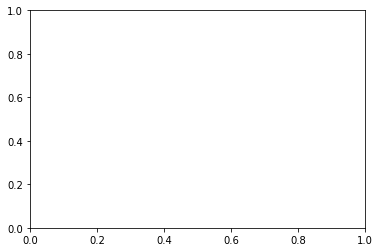

In [146]:
data_ts = pd.read_excel('Data/Russian_Universities_TS.xlsx', index_col = 0, parse_dates = True)
data_ts.dropna(inplace = True)
# data_ts.head()

# plt.plot(data_ts.Year.unique(), data_ts.Rank)
# data_ts.plot()
# plt.show()
plt.plot(data_ts.groupby('Year'))